<a href="https://colab.research.google.com/github/upendrak/pyspark_fundamentals/blob/main/PySpark_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-demo').getOrCreate()

We will use [bank dataset](https://www.kaggle.com/rouseguy/bankbalanced/data) downloaded from Kaggle for demonstraing some of PySpark ML algorithms

In [23]:
bank = spark.read.csv("bank.csv", header=True, inferSchema = True)

In [24]:
# Print schema
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [25]:
# Show the first 10 rows
bank.show(10)

+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.| married| tertiary|     no|    184|     no|  no|unkno

For ML, \
input variables are: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome \
output variable: deposit

In [26]:
# Let's check the distribution of classes
from pyspark.sql.functions import col
bank.filter(col('deposit').like("yes")).count(), bank.filter(col('deposit').like("no")).count()

(5289, 5873)

Our classes are perfect balanced

day and month columns are not really useful, we will remove these two columns

In [129]:
bank = bank.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = bank.columns

# Preprocess Data
To use algorithms like Logistic Regression, you must first convert the categorical variables in the dataset into numeric variables. There are two ways to do this.

1. Category Indexing: This is basically assigning a numeric value to each category from {0, 1, 2, ...numCategories-1}. This introduces an implicit ordering among your categories, and is more suitable for ordinal variables (eg: Poor: 0, Average: 1, Good: 2)

2. One-Hot Encoding: This converts categories into binary vectors with at most one nonzero value (eg: (Blue: [1, 0]), (Green: [0, 1]), (Red: [0, 0]))

We will use a combination of StringIndexer and either OneHotEncoder to convert the categorical variables. 

OneHotEncoder and OneHotEncoderEstimator return a SparseVector.

Since there is more than one stage of feature transformations, use a Pipeline to tie the stages together. This simplifies the code.

In [130]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

In [131]:
# Select all the categorial columns
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

Let's index each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables

In [132]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

We use the StringIndexer again to encode our labels to label indices

In [133]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

Next, we use the VectorAssembler to combine all the feature columns into a single vector column

In [134]:
# Select all the numerical variables
numericCols = [c[0] for c in bank.dtypes if c[1] == "int"]

# Concatenate them one by one and call this new vector “features”, which can be done using the PySpark VectorAssembler()
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [135]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
model = pipeline.fit(bank)
bank = model.transform(bank)
bank.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+-------------+----------------+-----+--------------------+
|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|poutcomeIndex|poutcomeclassVec|label|            features|
+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+----

In [136]:
# Select the specified columns
columns_selected = ['label', 'features'] + cols
bank = bank.select(columns_selected)
bank.show()

+-----+--------------------+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|label|            features|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|  1.0|(30,[3,11,13,16,1...| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[3,11,13,16,1...| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[2,11,13,16,1...| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[4,11,13,16,1...| 55|   services| married|secondary|     no|   2476|    yes|  no|un

we now have features column and label column appended to the original dataset (without date and time columns 

# Data Segregration
Let's randomly split data into train and test sets and set seed for reproducibility

In [38]:
train, test = bank.randomSplit([0.7, 0.3], seed = 2021)
train.count(), test.count()

(7816, 3346)

# Logistic Regression Model

In [39]:
from pyspark.ml.classification import LogisticRegression

In [40]:
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=5)
lr_model = lr.fit(train)

plot the LR model coeffficients

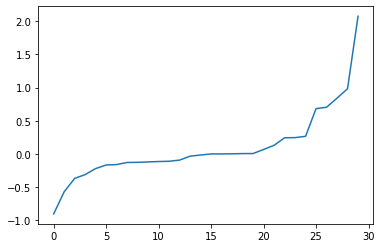

In [44]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.sort(lr_model.coefficients))

## ROC Curve

In [137]:
roc_df = lr_model.summary.roc
roc_df.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
| 2.43605359317905E-4|0.001616814874696...|
| 2.43605359317905E-4|0.003503098895176...|
|  4.8721071863581E-4|0.005119913769873349|
| 7.30816077953715E-4|0.006736728644570197|
| 7.30816077953715E-4|0.008623012665049851|
| 7.30816077953715E-4|0.010509296685529508|
|  9.7442143727162E-4|0.012126111560226353|
|  9.7442143727162E-4| 0.01401239558070601|
| 0.00146163215590743|0.015359741309620048|
| 0.00146163215590743|0.017246025330099703|
| 0.00146163215590743|0.019132309350579357|
| 0.00194884287454324|0.020479655079493397|
| 0.00194884287454324|0.022365939099973052|
| 0.00194884287454324|0.024252223120452707|
| 0.00194884287454324|0.026138507140932365|
| 0.00194884287454324| 0.02802479116141202|
|0.002192448233861145|0.029641606036108867|
| 0.00243605359317905| 0.03125842091080571|
|0.002679658952496955| 0.0328752

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Training set areaUnderROC: 0.89


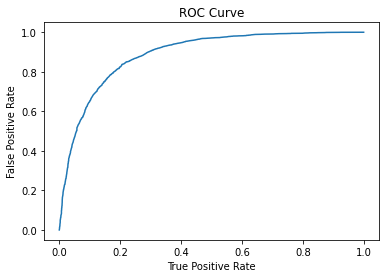

In [138]:
roc_df_pandas = roc_df.toPandas()
roc_df_pandas
plt.plot(roc_df_pandas['FPR'], roc_df_pandas['TPR'])
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve")

arc = round(lr_model.summary.areaUnderROC, 2)
print('Training set areaUnderROC: ' + str(arc))

# Model evaluation
For a binary classification problem, it is common practice to evaluate the performance of the model by plotting the ROC (Receiver Operating Characteristic) curve or calculating precision, recall, and F1-scores. For Random Forest classifier and Logistic Regression model, use the following code to calculate the AUC (area under ROC curve), precision, and recall, etc:

In [73]:
pred = lr_model.transform(test)
pred.show()

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|deposit|       rawPrediction|         probability|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 35|management|married|secondary|     no|    533|     no|  no|cellular|     221|      12|   -1|       0| unknown|     no|[1.79698140339589...|[0.85778108592123...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 37|management|married|secondary|     no|     80|     no|  no|cellular|     155|       3|   -1|       0| unknown|     no|[1.12219507827846...|[0.75439565388911.

In [153]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

#Calculate AUC
auc = evaluator.evaluate(pred,{evaluator.metricName: 'areaUnderROC'})
print(f'Area under the curve: {round(auc,2)}')

# compute TN, TP, FN, and FP
pred.groupBy('label').count().show()
TP = pred.filter('prediction == 1.0 AND label == 1.0').count()
TN = pred.filter('prediction == 0.0 AND label == 0.0').count()
FP = pred.filter('prediction == 1.0 AND label <> prediction').count()
FN = pred.filter('prediction == 0.0 AND label <> prediction').count()

# Calculate accuracy, precistion, recall and F1-score
accuracy = round((TP + TN)/(TP + TN + FP + FN) * 100, 2)
precision = round(TP / (TP + FP), 2)
recall = round(TP / (TP + FN), 2)
F1 = round(2 * (precision * recall) / (precision + recall), 2)

print(f'Accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'F1: {F1}')


Area under the curve: 0.88
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1768|
|  1.0| 1578|
+-----+-----+

Accuracy: 79.92
precision: 0.8
recall: 0.76
F1: 0.78


# Decision Tree Classifier

In [154]:
from pyspark.ml.classification import DecisionTreeClassifier

In [156]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=30)
dt_model = dt.fit(train)

In [157]:
pred_dt = dt_model.transform(test)

In [158]:
evaluator = BinaryClassificationEvaluator()

#Calculate AUC
auc = evaluator.evaluate(pred_dt,{evaluator.metricName: 'areaUnderROC'})
print(f'Area under the curve: {round(auc,2)}')

# compute TN, TP, FN, and FP
pred_dt.groupBy('label').count().show()
TP = pred_dt.filter('prediction == 1.0 AND label == 1.0').count()
TN = pred_dt.filter('prediction == 0.0 AND label == 0.0').count()
FP = pred_dt.filter('prediction == 1.0 AND label <> prediction').count()
FN = pred_dt.filter('prediction == 0.0 AND label <> prediction').count()

# Calculate accuracy, precistion, recall and F1-score
accuracy = round((TP + TN)/(TP + TN + FP + FN) * 100, 2)
precision = round(TP / (TP + FP), 2)
recall = round(TP / (TP + FN), 2)
F1 = round(2 * (precision * recall) / (precision + recall), 2)

print(f'Accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'F1: {F1}')


Area under the curve: 0.79
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1768|
|  1.0| 1578|
+-----+-----+

Accuracy: 75.04
precision: 0.73
recall: 0.74
F1: 0.73
